In [10]:
import numpy as np
import cv2
import PIL.Image as Image
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential


In [11]:
from tensorflow import keras
import PIL
import cv2
import matplotlib.pylab as plt
import numpy as np
from skimage.feature import greycomatrix, greycoprops
import pandas as pd
import pathlib


In [12]:
data_dir=r"C:\Users\COMPUTER CARE\OneDrive\Desktop\kidney(agu)\kidney(agu)"
data_dir = pathlib.Path(data_dir)
images_dict = {
    'Normal': list(data_dir.glob('normal/*')),
    'Cyst': list(data_dir.glob('cyst/*')),
    'Stone': list(data_dir.glob('stone/*')),
    'Tumor': list(data_dir.glob('tumor/*'))
    
}
labels_dict = {
    'Normal':0,
    'Cyst':1,
    'Stone':2,
    'Tumor':3
}

In [13]:
X, Y = [], []
for image_type, images in images_dict.items():
    
        
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224)) 
        X.append(resized_img)
        Y.append(labels_dict[image_type])

In [14]:
X=np.array(X)
Y=np.array(Y)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2)

In [16]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3),
 pooling='avg',classes=4,
 weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

In [17]:
    resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
resnet_model.compile(
 optimizer="adam",
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 metrics=['accuracy'])
resnet_model.fit(X_train, y_train, epochs=3,steps_per_epoch=50)


Epoch 1/3
50/50 [==============================] - 428s 9s/step - loss: 0.9234 - accuracy: 0.7098
Epoch 2/3
50/50 [==============================] - 420s 8s/step - loss: 0.2105 - accuracy: 0.9346
Epoch 3/3
50/50 [==============================] - 418s 8s/step - loss: 0.1239 - accuracy: 0.9613


In [19]:
resnet_model.save('Resnet50agu.h5')

In [20]:
resnet_model = tf.keras.models.load_model('Resnet50agu.h5')
resnet_model.evaluate(X_test,y_test)

38/38 [==============================] - 107s 3s/step - loss: 0.1234 - accuracy: 0.9592


[0.1233537569642067, 0.9591666460037231]

In [21]:
predictions=resnet_model.predict(X_test)

38/38 [==============================] - 108s 3s/step


In [22]:
predictions=np.array(predictions)
y_pred=[]
for i in predictions:
    i=list(i)
    y_pred.append(i.index(max(i[0],i[1],i[2],i[3])))
y_pred=np.array(y_pred)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       324
           1       0.89      0.99      0.94       277
           2       0.97      0.86      0.91       283
           3       0.99      0.99      0.99       316

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



<Axes: >

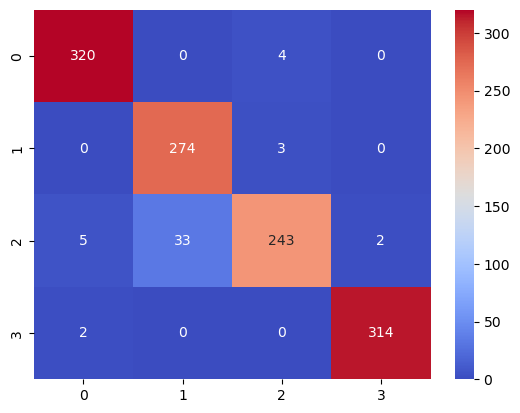

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
cf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(cf_matrix, annot=True,cmap='coolwarm',fmt='.3g')